#  NOTEBOOK SPECIAL USE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Import des librairies pour la réduction dimensionnelle et le clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Import de tensorflow pour USE
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memory_efficient_attentio

In [2]:
#pip install transformers

In [3]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
Num GPUs Available:  0
True


In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
file = pd.read_csv("/content/drive/MyDrive/Projet6_ClassifierAutomatiquementdesBiens/cleaned_description.csv")
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
file.head()

,product_category_tree,description,main_category,pre_clean_desc,cleaned_desc,final_desc
0,Home Furnishing >> Curtains & Accessories >> C...,Key Features of Elegance Polyester Multicolor ...,home furnishing,key feature elegance polyester multicolor abst...,key elegance polyester multicolor abstract eye...,elegance polyester multicolor abstract eyelet ...
1,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Specifications of Sathiyas Cotton Bath Towel (...,baby care,specification sathiyas cotton bath towel 3 bat...,cotton bath towel bath towel red yellow blue b...,cotton bath towel bath towel yellow bath towel...
2,Baby Care >> Baby Bath & Skin >> Baby Bath Tow...,Key Features of Eurospa Cotton Terry Face Towe...,baby care,key feature eurospa cotton terry face towel se...,key cotton terry face towel set size small hei...,cotton terry face towel set small inch cotton ...
3,Home Furnishing >> Bed Linen >> Bedsheets >> S...,Key Features of SANTOSH ROYAL FASHION Cotton P...,home furnishing,key feature santosh royal fashion cotton print...,key royal fashion cotton printed king sized do...,royal fashion cotton printed king sized double...
4,Home Furnishing >> Bed Linen >> Bedsheets >> J...,Key Features of Jaipur Print Cotton Floral Kin...,home furnishing,key feature jaipur print cotton floral king si...,key print cotton floral king sized double cott...,print cotton floral king sized double cotton p...


In [6]:
# Copie du fichier
data = file.copy()

In [7]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [8]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [9]:
batch_size = 8
sentences = data['final_desc'].to_list()
features_USE = feature_USE_fct(sentences, batch_size)

In [10]:
# T-SNE

start_use = time.time()

tsne_use = TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=42)
X_tsne_use = tsne_use.fit_transform(features_USE)

stop_use = time.time() - start_use

print("Temps de T-SNE : ", "%15.2f" % stop_use, "secondes")

Temps de T-SNE :             9.64 secondes


In [11]:
# Création du dataframe
df_tsne_use = pd.DataFrame(X_tsne_use, columns=['tsne1', 'tsne2'])
df_tsne_use["class"] = data["main_category"]
df_tsne_use.head()

,tsne1,tsne2,class
0,-25.119051,33.506760,home furnishing
1,-13.849757,23.794964,baby care
2,-12.801732,24.699043,baby care
3,-17.072788,34.197662,home furnishing
4,-16.694456,33.588722,home furnishing


In [12]:
# Réalisation du k-means avec 7 clusters (7 catégories de produits)
kmeans_tsne_use = KMeans(n_clusters=7, init='k-means++', random_state=42)
kmeans_tsne_use.fit_predict(X_tsne_use)

# Récupération des clusters
kmeans_tsne_use_labels = kmeans_tsne_use.labels_

# Ajout des clusters au dataframe précédent
df_tsne_use["cluster"] = kmeans_tsne_use_labels

print(df_tsne_use.head())
print()
ari_use = adjusted_rand_score(df_tsne_use['class'],df_tsne_use['cluster'])
print(f'ARI après modélisation avec USE : {ari_use}')

       tsne1      tsne2             class  cluster
0 -25.119051  33.506760  home furnishing         5
1 -13.849757  23.794964        baby care         5
2 -12.801732  24.699043        baby care         5
3 -17.072788  34.197662  home furnishing         5
4 -16.694456  33.588722  home furnishing         5

ARI après modélisation avec USE : 0.4197765659286557


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


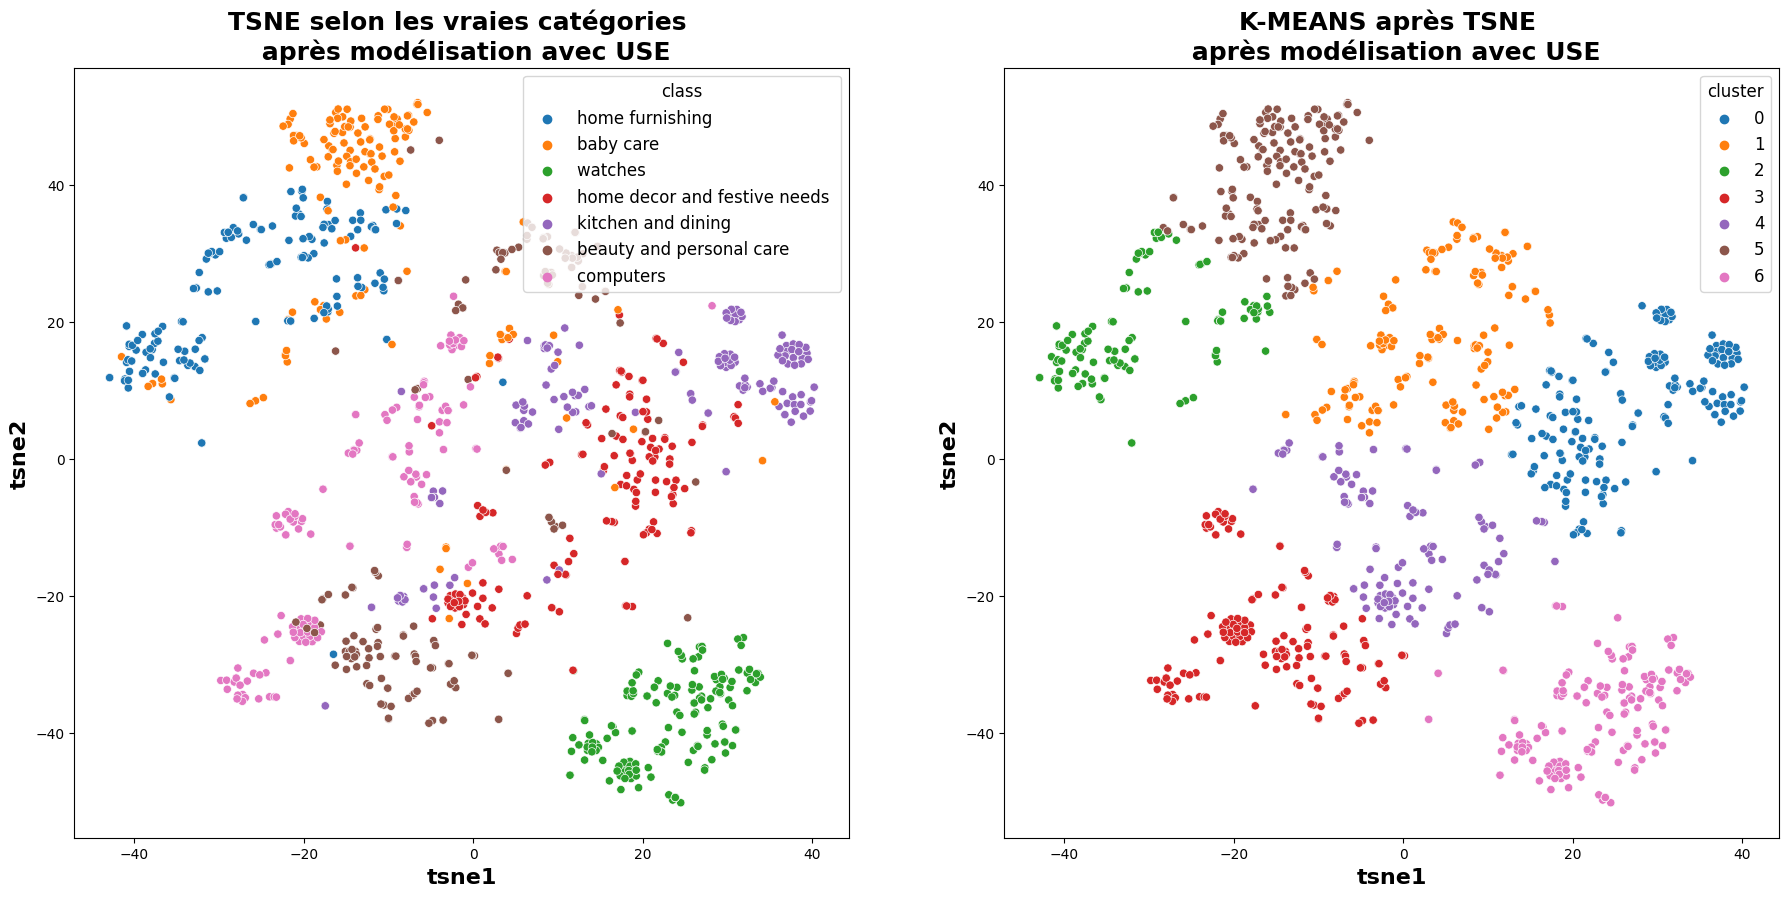

In [13]:
# Visualisation par nuages de points
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 10))
with sns.color_palette(palette="tab10"):
    plt.rcParams.update({"font.size":12})
    sns.scatterplot(ax=axes[0], data= df_tsne_use, x="tsne1", y="tsne2", hue="class", legend="brief")
    axes[0].set_xlabel("tsne1", fontname= "sans-serif", fontsize = 16, fontweight = "bold")
    axes[0].set_ylabel("tsne2", fontname= "sans-serif", fontsize = 16, fontweight = "bold")
    axes[0].set_title("TSNE selon les vraies catégories \n après modélisation avec USE", fontname= "sans-serif", fontsize = 18, fontweight = "bold")
    sns.scatterplot(ax=axes[1], data= df_tsne_use, x="tsne1", y="tsne2", hue="cluster", palette="tab10", legend="brief")
    axes[1].set_xlabel("tsne1", fontname= "sans-serif", fontsize = 16, fontweight = "bold")
    axes[1].set_ylabel("tsne2", fontname= "sans-serif", fontsize = 16, fontweight = "bold")
    axes[1].set_title("K-MEANS après TSNE \n après modélisation avec USE", fontname= "sans-serif", fontsize = 18, fontweight = "bold")
plt.show()

**Nous pouvons remarquer non seulement au niveau visuel mais aussi au niveau du score ARI (0.42) que cette approche donne de meilleurs résultats que BERT. Néanmoins, elle reste moins performante qu'un simple tf-ifd ou que le Word2Vect.**